# 1. Loading templates

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from tqdm.notebook import tqdm
import json
import yaml
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

In [2]:
# load workspace
workspace_file = '2d_2channels_workspace_3_0.json'
results = 'results_3.yaml'

with open(workspace_file, encoding="utf-8") as ws_file:
    ws = json.load(ws_file)
electron_channel = ws['channels'][0]
samples_name = [s['name'] for s in electron_channel['samples']]
templates = np.array([s['data'] for s in electron_channel['samples']])

# 2. Loading data

In [3]:
# Load all generic bbar
training_variables = util.training_variables
variables = util.variables
folder = '../Samples/Generic_MC14ri/MC14ri_bbbar_bengal_e_1'
pfs = glob.glob(f"{folder}/*.parquet")

dfs=[]
for file_path in tqdm(pfs, desc ="Looping over chunks"):
    df = pd.read_parquet(file_path, engine="pyarrow",
                         columns=['D_mcPDG', 'e_mcPDG','DecayMode', 
                                    'p_D_l', 'B_D_ReChi2','e_genMotherPDG','B0_mcPDG',
                                    'B0_mcErrors','B0_isContinuumEvent']+variables)
    dfs.append(df)
    del df
df = pd.concat(dfs,ignore_index=True).reset_index()

Looping over chunks:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# Apply MVA
import lightgbm as lgb
bst_lgb = lgb.Booster(model_file=f'../BDTs/LightGBM/lgbm_multiclass.txt')

pred = bst_lgb.predict(df[training_variables], num_iteration=50) #bst_lgb.best_iteration
lgb_out = pd.DataFrame(pred, columns=['signal_prob','continuum_prob','fakeD_prob','fakeB_prob'])

df_lgb = pd.concat([df, lgb_out], axis=1)
df_lgb['largest_prob'] = df_lgb[['signal_prob','continuum_prob','fakeD_prob','fakeB_prob']].max(axis=1)
del pred, df, lgb_out

In [5]:
df, samples=util.get_dataframe_samples(df_lgb)
# remove the bkg component, will be included back later
df = df.drop(df[df['mode'].isin(['bkg_continuum','bkg_fakeDTC','bkg_fakeB','bkg_others'])].index)

In [6]:
NumberOfEvents = {'small_pDl':{},'large_pDl':{}}
for name, sample in samples.items():
    NumberOfEvents['small_pDl'][name]=len(sample.query('p_D_l<2.5'))
    NumberOfEvents['large_pDl'][name]=len(sample.query('p_D_l>2.5'))
NumberOfEvents

{'small_pDl': {'$D\\tau\\nu$': 15071,
  '$D^\\ast\\tau\\nu$': 10677,
  '$D\\ell\\nu$': 44684,
  '$D^\\ast\\ell\\nu$': 102135,
  '$D^{\\ast\\ast}\\tau\\nu$': 11374,
  '$D^{\\ast\\ast}\\ell\\nu$': 173689,
  'bkg_fakeDTC': 4496220,
  'bkg_fakeB': 790037,
  'bkg_continuum': 0,
  'bkg_others': 929},
 'large_pDl': {'$D\\tau\\nu$': 3904,
  '$D^\\ast\\tau\\nu$': 1403,
  '$D\\ell\\nu$': 436471,
  '$D^\\ast\\ell\\nu$': 263122,
  '$D^{\\ast\\ast}\\tau\\nu$': 711,
  '$D^{\\ast\\ast}\\ell\\nu$': 162540,
  'bkg_fakeDTC': 1725084,
  'bkg_fakeB': 121191,
  'bkg_continuum': 0,
  'bkg_others': 970}}

In [7]:
cut='signal_prob==largest_prob and signal_prob>0.8'
xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
yedges = np.linspace(0.4, 4.6, 42)
variable_x = 'B0_CMS3_weMissM2'
variable_y = 'p_D_l'

(counts, xedges, yedges) = np.histogram2d(df.query(cut)[variable_x], 
                                          df.query(cut)[variable_y],
                                          bins=[xedges, yedges])
counts = counts.T

In [8]:
# split templates and data at p_D_l==2.5
p_D_l_slice = 2.5
p_D_l_slice_index, = np.asarray(np.isclose(yedges,p_D_l_slice,atol=0.1)).nonzero()
counts_small_pDl = counts[:p_D_l_slice_index[0]]
counts_large_pDl = counts[p_D_l_slice_index[0]:]
indices_non_zero_small_pDl = np.where(counts_small_pDl != 0)
indices_non_zero_large_pDl = np.where(counts_large_pDl != 0)
data_small_pDl = counts_small_pDl[indices_non_zero_small_pDl]
data_large_pDl = counts_large_pDl[indices_non_zero_large_pDl]

templates_small_pDl = [t.reshape(counts.shape)[:p_D_l_slice_index[0]][indices_non_zero_small_pDl] for t in templates]
templates_large_pDl = [t.reshape(counts.shape)[p_D_l_slice_index[0]:][indices_non_zero_large_pDl] for t in templates]

# for plotting projections
templates_2d = [t.reshape(counts.shape) for t in templates]
templates_small_pDl_2d = [t.reshape(counts.shape)[:p_D_l_slice_index[0]] for t in templates]
templates_large_pDl_2d = [t.reshape(counts.shape)[p_D_l_slice_index[0]:] for t in templates]
data_2d = counts
data_small_pDl_2d = counts[:p_D_l_slice_index[0]]
data_large_pDl_2d = counts[p_D_l_slice_index[0]:]

# 3. Fitting with iminuit

In [9]:
df.query(cut)['mode'].value_counts()

$D\ell\nu$               144129
$D^\ast\ell\nu$           95339
$D^{\ast\ast}\ell\nu$     60091
$D\tau\nu$                 8728
$D^\ast\tau\nu$            4322
$D^{\ast\ast}\tau\nu$      2582
Name: mode, dtype: int64

In [24]:
from iminuit import Minuit
from iminuit.cost import poisson_chi2, Template
from IPython.display import display

indices_non_zero = np.where(counts != 0)
temp = [i.reshape(counts.shape)[indices_non_zero] for i in templates]
# data = counts.ravel().to_list()
data = counts[indices_non_zero]
xedge = np.linspace(0, len(data), len(data)+1)
init_yields = [3000]*6

## Barlow-Beeston method

In [34]:
class BB:
    def __init__(self, data, temp):
        # data, template are input argument of the class itself
        self.data = data, temp

    def __call__(self, par):
        # get number of bins and components from data, template
        data, temp = self.data
        bins = len(data)
        nComp = temp.shape[0]
        # formate fitting parameters
        yields = par[:nComp]
        nuisances = par[nComp:]
        temp_nuisances = [nuisances[x:x+bins] for x in np.arange(nComp)*bins]
        # initialize cost function calculation
        fitted_total = 0 # fitted count at each bin
        cost = 0
        # calculate the cost function
        for y, t_nui, i in zip(yields, temp_nuisances, range(len(yields))):
            fitted_total += y * t_nui / np.sum(t_nui)
            cost += poisson_chi2(temp[i], t_nui)
        cost += poisson_chi2(data, fitted_total)
        return cost

    @property
    def ndata(self):
        data, temp = self.data
        return np.prod(data.shape) + np.prod(temp.shape)
    
    def errordef(self):
        return Minuit.LEAST_SQUARES

In [ ]:
m1 = Minuit(BB(data, temp), np.concatenate([init_yields, np.concatenate(temp)]))
m1.limits = (0, None)
m1.migrad(ncall=100000)
m1.hesse()

## Barlow-Beeston-Lite method

In [ ]:
c2 = Template(data, xedge, temp, method="jsc")
m2 = Minuit(c2, *init_yields, name=samples_name)
m2.limits = (0, None)
m2.migrad()
m2.hesse()
#m2.minos()

In [26]:
c3 = Template(data, xedge, temp, method="asy")
m3 = Minuit(c3, *init_yields, name=samples_name)
m3.limits = (0, None)
m3.simplex().migrad()
m3.hesse()
m3.minos()

E VariableMetricBuilder Initial matrix not pos.def.


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2449                       │             Nfcn = 1756              │
│ EDM = 4.1e-06 (Goal: 0.0001)     │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │   4.4e3   │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
│ 1 │ $D^\ast\tau\nu$       │   4.1e3   │   1.0e3   │   -0.9e3   │   1.0e3    │    0    │         │       │
│ 2 │ $D\ell\nu$            │  148.5e3  │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
│ 3 │ $D^\ast\ell\nu$       │  94.9e3   │   1.4e3   │   -1.4e3   │   1.4e3    │    0    │         │       │
│ 4 │ $D^{\ast\ast}\tau\nu$ │   3.7e3   │   0.9e3   │   -0.9e3   │   0.9e3    │    0    │         │       │
│ 5 │ $D^{\ast\ast}\ell\nu$ │  58.3e3   │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │      $D\tau\nu$       │    $D^\ast\tau\nu$    │      $D\ell\nu$       │    $D^\ast\ell\nu$    │ $D^{\ast\ast}\tau\nu$ │ $D^{\ast\ast}\ell\nu$ │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -1.2e3   │   1.2e3   │  -0.9e3   │   1.0e3   │  -1.2e3   │   1.2e3   │  -1.4e3   │   1.4e3   │  -0.9e3   │   0.9e3   │  -1.2e3   │   1.2e3   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\tau\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │              1.46e+06             -3.61e+05              -6.6e+04              2.85e+05  

In [29]:
# fit the whole generic MC
c4 = Template(data, xedge, temp, method="da")
m4 = Minuit(c4, *init_yields, name=samples_name)
m4.limits = (0, None)
m4.simplex().migrad()
m4.hesse()
m4.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 540.9 (chi2/ndof = 0.9)    │             Nfcn = 1431              │
│ EDM = 1.4e-06 (Goal: 0.0002)     │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │   2.2e3   │   1.0e3   │   -0.9e3   │   1.1e3    │    0    │         │       │
│ 1 │ $D^\ast\tau\nu$       │   4.8e3   │   1.2e3   │   -1.1e3   │   1.2e3    │    0    │         │       │
│ 2 │ $D\ell\nu$            │  149.3e3  │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
│ 3 │ $D^\ast\ell\nu$       │  93.9e3   │   1.4e3   │   -1.4e3   │   1.4e3    │    0    │         │       │
│ 4 │ $D^{\ast\ast}\tau\nu$ │   3.9e3   │   1.0e3   │   -1.0e3   │   1.0e3    │    0    │         │       │
│ 5 │ $D^{\ast\ast}\ell\nu$ │  61.2e3   │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │      $D\tau\nu$       │    $D^\ast\tau\nu$    │      $D\ell\nu$       │    $D^\ast\ell\nu$    │ $D^{\ast\ast}\tau\nu$ │ $D^{\ast\ast}\ell\nu$ │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.9e3   │   1.1e3   │  -1.1e3   │   1.2e3   │  -1.2e3   │   1.2e3   │  -1.4e3   │   1.4e3   │   -1e3    │    1e3    │  -1.2e3   │   1.2e3   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\tau\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │              1.01e+06             -2.86e+05             -3.89e+04              1.97e+05  

In [19]:
# fit the p_D_l<2.5 region
small_truth = NumberOfEvents['small_pDl'].values()
new_edge = np.linspace(0, len(data_small_pDl), len(data_small_pDl)+1)
c6 = Template(data_small_pDl, new_edge, templates_small_pDl, method="da")
m6 = Minuit(c6, *small_truth, name=samples_name)
m6.limits = (0, None)
m6.simplex().migrad()
m6.hesse()
m6.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 584.8 (chi2/ndof = 1.5)    │              Nfcn = 904              │
│ EDM = 2.32e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │  10.6e3   │   3.1e3   │   -3.0e3   │   3.0e3    │    0    │         │       │
│ 1 │ $D^\ast\tau\nu$       │  11.6e3   │   2.6e3   │   -2.6e3   │   2.7e3    │    0    │         │       │
│ 2 │ $D\ell\nu$            │  35.1e3   │   1.2e3   │   -1.2e3   │   1.2e3    │    0    │         │       │
│ 3 │ $D^\ast\ell\nu$       │  89.0e3   │   1.6e3   │   -1.6e3   │   1.6e3    │    0    │         │       │
│ 4 │ $D^{\ast\ast}\tau\nu$ │  15.4e3   │   2.0e3   │   -2.0e3   │   2.0e3    │    0    │         │       │
│ 5 │ $D^{\ast\ast}\ell\nu$ │  156.6e3  │   2.7e3   │   -2.6e3   │   2.7e3    │    0    │         │       │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │      $D\tau\nu$       │    $D^\ast\tau\nu$    │      $D\ell\nu$       │    $D^\ast\ell\nu$    │ $D^{\ast\ast}\tau\nu$ │ $D^{\ast\ast}\ell\nu$ │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -3e3    │    3e3    │  -2.6e3   │   2.7e3   │  -1.2e3   │   1.2e3   │  -1.6e3   │   1.6e3   │   -2e3    │    2e3    │  -2.6e3   │   2.7e3   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\tau\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │              9.49e+06             -2.34e+06             -3.05e+05               1.1e+06  

In [20]:
# fit the p_D_l>2.5 region
large_truth = NumberOfEvents['large_pDl'].values()
new_edge = np.linspace(0, len(data_large_pDl), len(data_large_pDl)+1)
c7 = Template(data_large_pDl, new_edge, templates_large_pDl, method="da")
m7 = Minuit(c7, *large_truth, name=samples_name)
m7.limits = (0, None)
m7.simplex().migrad()
m7.hesse()
#m7.minos()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 215.8 (chi2/ndof = 0.8)    │              Nfcn = 424              │
│ EDM = 0.000128 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name                  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ $D\tau\nu$            │  14.6e3   │   2.1e3   │            │            │    0    │         │       │
│ 1 │ $D^\ast\tau\nu$       │     0     │    50     │            │            │    0    │         │       │
│ 2 │ $D\ell\nu$            │  439.7e3  │   2.9e3   │            │            │    0    │         │       │
│ 3 │ $D^\ast\ell\nu$       │   277e3   │    4e3    │            │            │    0    │         │       │
│ 4 │ $D^{\ast\ast}\tau\nu$ │     0     │    34     │            │            │    0    │         │       │
│ 5 │ $D^{\ast\ast}\ell\nu$ │   159e3   │    4e3    │            │            │    0    │         │       │
└───┴───────────────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────────────────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                       │            $D\tau\nu$       $D^\ast\tau\nu$            $D\ell\nu$       $D^\ast\ell\nu$ $D^{\ast\ast}\tau\nu$ $D^{\ast\ast}\ell\nu$ │
├───────────────────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│            $D\tau\nu$ │              4.58e+06                   -91             -9.96e+05              3.67e+06                 -16.7             -7.42e+06 │
│       $D^\ast\tau\nu$ │                   -91                  46.4                  3.86                  7.15              9.11e-06                  2.03 │
│            $D\ell\nu$ │             -9.96e+05                  3.86              8.32e+06             -7.79e+06                  6.65              3.08e+06 │
│       $D^\ast\ell\nu$ │              3.67e+06                  7.15             -7.79e+06              1.55e+07                 -17.3             -9.92e+06 │
│ $D^{\ast\ast}\tau\nu$ │                 -16.7              9.11e-06                  6.65                 -17.3                  3.26                  22.9 │
│ $D^{\ast\ast}\ell\nu$ │             -7.42e+06                  2.03              3.08e+06             -9.92e+06                  22.9              1.55e+07 │
└───────────────────────┴─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

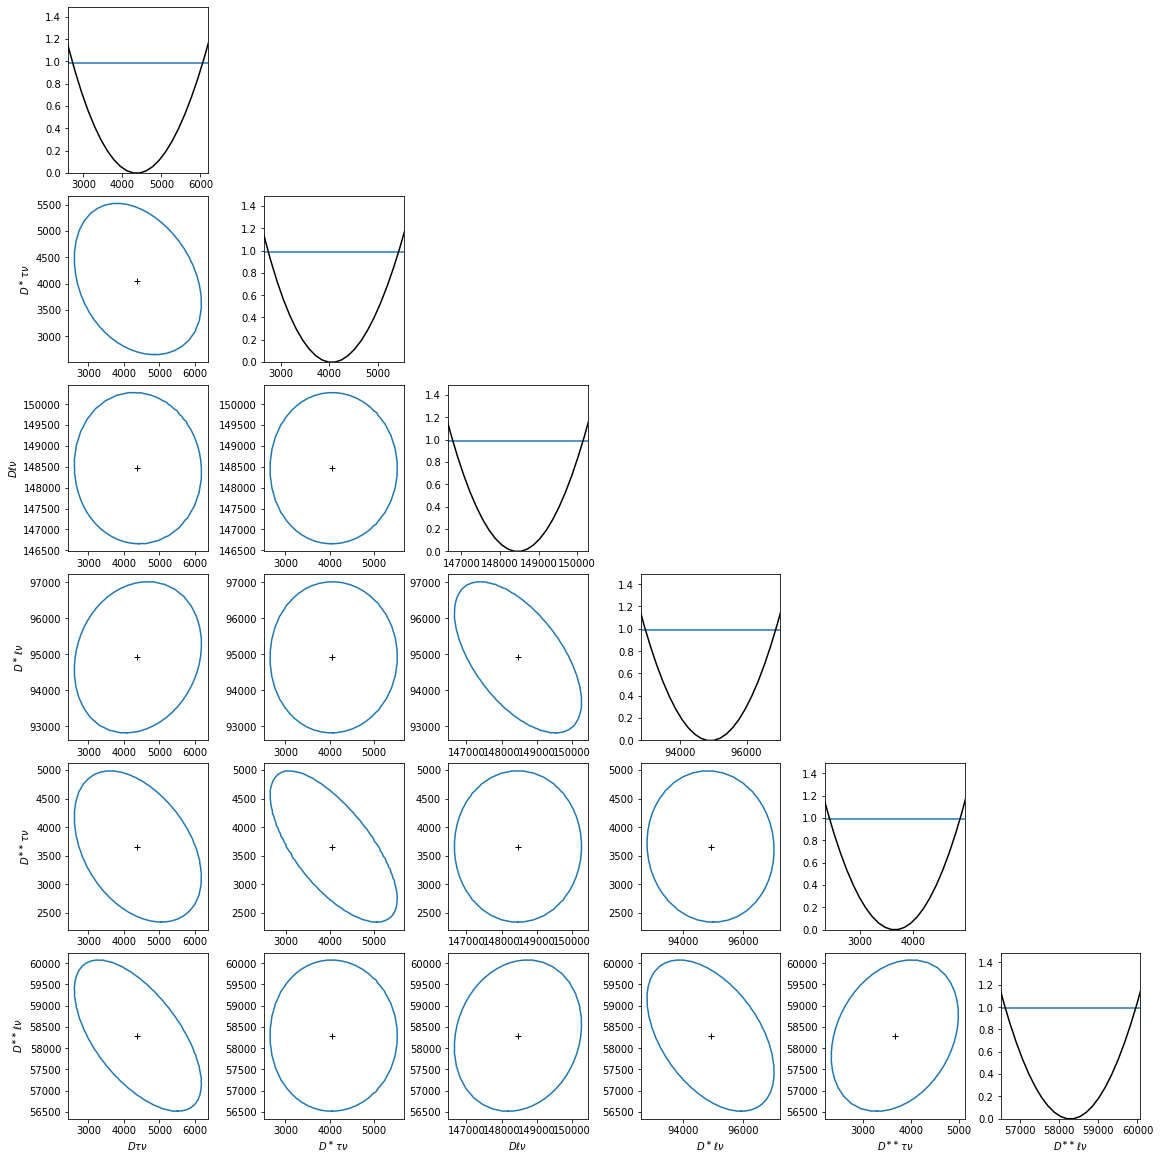

In [31]:
m3.draw_mnmatrix(figsize=(16,16));

In [109]:
def calculate_R(m):
    tau_e_BF = 0.17
    eff_D_tau_nu = 12194/50000
    #eff_D_tau_nu_err = eff_D_tau_nu*np.sqrt(1/12194 + 1/50000)
    eff_D_l_nu = 14108/50000
    #eff_D_l_nu_err = eff_D_l_nu*np.sqrt(1/14108 + 1/50000)
    R_D = m.values[r'$D\tau\nu$']/m.values[r'$D\ell\nu$']/tau_e_BF * eff_D_l_nu/eff_D_tau_nu
    R_D_err = R_D*np.sqrt( (m.errors[r'$D\tau\nu$']/m.values[r'$D\tau\nu$'])**2 + (m.errors[r'$D\ell\nu$']/m.values[r'$D\ell\nu$'])**2 + 1/12194 + 1/50000 + 1/14108 + 1/50000)

    eff_Dst_tau_nu = 2260/10000
    eff_Dst_l_nu = 2466/10000
    R_Dst = m.values[r'$D^\ast\tau\nu$']/m.values[r'$D^\ast\ell\nu$']/tau_e_BF * eff_Dst_l_nu/eff_Dst_tau_nu
    R_Dst_err = R_Dst*np.sqrt( (m.errors[r'$D^\ast\tau\nu$']/m.values[r'$D^\ast\tau\nu$'])**2 + (m.errors[r'$D^\ast\ell\nu$']/m.values[r'$D^\ast\ell\nu$'])**2 + 1/2260 + 1/10000 + 1/2466 + 1/10000)

    print(f'{R_D = :.3f} ± {R_D_err:.3f}')
    print(f'{R_Dst = :.3f} ± {R_Dst_err:.3f}')
    
calculate_R(m2)

R_D = 0.291 ± 0.042
R_Dst = 0.226 ± 0.049


In [112]:
calculate_R(m4)

R_D = 0.306 ± 0.041
R_Dst = 0.215 ± 0.054


In [ ]:
# split the sample to 10 pieces and fit each one
folder = '/home/belle/zhangboy/R_D/Generic_MC14ri/MC14ri_bbbar_bengal_e_1'
pfs = glob.glob(f"{folder}/sub0?_?.parquet")
chunkNum = 0

for file_path in tqdm(pfs, desc ="Looping over chunks"):
    samples = {}

    df_bestSelected = pandas.read_parquet(file_path, engine="pyarrow")

    # Signal components
    sig_D_tau_nu=df_bestSelected.query(f'DecayMode=="sig_D_tau_nu" and B0_mcErrors<32 and {signals_selection}').copy()
    sig_Dst_tau_nu=df_bestSelected.query(f'DecayMode=="sig_Dst_tau_nu" and B0_mcErrors<64 and {signals_selection}').copy()
    sig_D_e_nu=df_bestSelected.query(f'DecayMode=="sig_D_e_nu" and B0_mcErrors<16 and {norms_selection}').copy()
    sig_Dst_e_nu=df_bestSelected.query(f'DecayMode=="sig_Dst_e_nu" and B0_mcErrors<64 and {norms_selection}').copy() 
    all_Dstst_tau_nu=df_bestSelected.query(Dstst_tau_nu_selection).copy() 
    all_Dstst_e_nu=df_bestSelected.query(Dstst_e_nu_selection).copy()

    samples['$D\\tau\\nu$'] = sig_D_tau_nu
    samples['$D^\\ast\\tau\\nu$'] = sig_Dst_tau_nu
    samples['$D\ell\\nu$'] = sig_D_e_nu
    samples['$D^\\ast\ell\\nu$'] = sig_Dst_e_nu
    samples['$D^{\\ast\\ast}\\tau\\nu$'] = all_Dstst_tau_nu
    samples['$D^{\\ast\\ast}\ell\\nu$'] = all_Dstst_e_nu
    
    print(f'file: {file_path}')
    for name in samples:
          print(f'{name}: {len(samples[name])}')



    sample_list = []
    for name in samples:
        sample_list.append(samples[name].reset_index(drop=True))
    df_merged = pandas.concat(sample_list)

    
    cut='B0_roeMbc_my_mask>4.26'
    xedges = np.linspace(-2, 10, 48) # -7.5 for weMiss2, -2 for weMiss3, -2.5 for weMiss4
    yedges = np.linspace(0.4, 4.6, 42)
    variable_x = 'B0_CMS3_weMissM2'
    variable_y = 'p_D_l'

    (counts, xedges, yedges) = np.histogram2d(df_merged.query(cut)[variable_x], 
                                              df_merged.query(cut)[variable_y],
                                              bins=[xedges, yedges])
    counts = counts.T
    
    
    
    
    
    data = counts.ravel().tolist()
    init_yields = [len(value) for key, value in samples.items()]

    xedge = np.linspace(0, 1927, 1928)
    ci = Template(data, xedge, temp, method="jsc")
    mi = Minuit(ci, *init_yields, name=samples_name)
    mi.limits = (0, None)
    mi.strategy = 0
    mi.simplex(ncall=10000000).migrad(ncall=10000000)
    #assert mi.valid

    for i in samples_name:
        print(f'{i=}')
        print(f'{mi.values[i]} ± {mi.errors[i]}\n')
        
        with open(results, 'r+') as f:
            data = yaml.safe_load(f)
            data['signal_e'][i]['difference'][chunkNum]=mi.values[i] - len(samples[i])
            data['signal_e'][i]['errors'][chunkNum]=mi.errors[i]
            f.seek(0)        # <--- should reset file position to the beginning.
            yaml.dump(data, f, indent=4)
            f.truncate()     # remove remaining part
    
    sum_event = round(np.sum(mi.values))
    print(f'\n{sum_event=}')
    print(f'Total fitted counts uncertainty: ')
    print(f'Total generated counts: {len(df_merged)}')
    #print(f'\n{fit_results=}')
    
    with open(results, 'r+') as f:
        data = yaml.safe_load(f)
        data['signal_e']['sum']['difference'][chunkNum]=sum_event - len(df_merged)
        f.seek(0)        # <--- should reset file position to the beginning.
        yaml.dump(data, f, indent=4)
        f.truncate()     # remove remaining part

    chunkNum += 1

In [7]:
init_yields

[2393, 1530, 62358, 47091, 907, 29547]

# Plot the fitting results

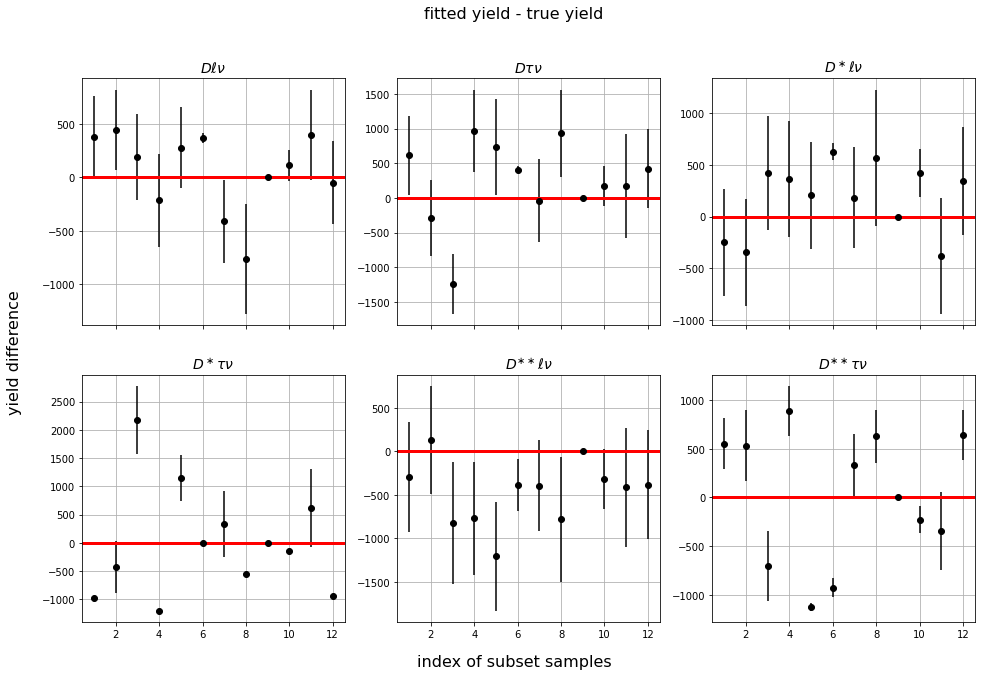

In [13]:
mpl.plot_fitting_difference('results_3.yaml')

## Define the slices of projection

In [32]:
from matplotlib import gridspec
import mplhep as hep

print(counts.shape)
p_D_l_slice = 2.5
mm2_slice = 2.4
p_D_l_slice_index, = np.asarray(np.isclose(yedges,p_D_l_slice,atol=0.1)).nonzero()
mm2_slice_index, = np.asarray(np.isclose(xedges,mm2_slice,atol=0.1)).nonzero()
print([mm2_slice_index[0], p_D_l_slice_index[0]])

(41, 47)
[17, 20]


## Plot with mplhep or plt.bar()

In [33]:
# plotting version: residual = data - all_temp
def plot_projection_residual(Minuit, templates_2d, data_2d, direction='MM2', slices=False, plot_with='mplhep'):
    if direction not in ['MM2', 'p_D_l'] or plot_with not in ['mplhep', 'pltbar']:
        raise ValueError('direction in [MM2, p_D_l] and plot_with in [mplhep, pltbar]')
    fitted_components_names = samples_name
        # fitted_templates_2d = templates / normalization * yields
    fitted_templates_2d = [templates_2d[i]/templates_2d[i].sum() * Minuit.values[i] for i in range(len(templates_2d))]
    # fitted_templates_err = templates_2d_err, yields_err in quadrature
                         # = fitted_templates_2d x sqrt( (1/templates_2d) + (yield_err/yield)**2 ) if templates_2d[i,j]!=0
                         # = 0 if yield ==0 or templates_2d[i,j]==0
    fitted_templates_err = np.zeros_like(templates_2d)
    non_zero_masks = [np.where(t!= 0) for t in templates_2d]
    for i in range(len(templates_2d)):
        if Minuit.values[i]==0:
            continue
        else:
            fitted_templates_err[i][non_zero_masks[i]] = fitted_templates_2d[i][non_zero_masks[i]] * \
            np.sqrt(1/templates_2d[i][non_zero_masks[i]] + (Minuit.errors[i]/Minuit.values[i])**2)

    
    def extend(x):
        return np.append(x, x[-1])
    
    def errorband(bins, template_sum, template_err, ax):
        fitted_sum = np.sum(template_sum, axis=0)
        fitted_err = np.sqrt(np.sum(np.array(template_err)**2, axis=0)) # assuming the correlations between each template are 0
        ax.fill_between(bins, extend(fitted_sum - fitted_err), extend(fitted_sum + fitted_err),
        step="post", color="black", alpha=0.3, linewidth=0, zorder=100,)
        
    def plot_with_hep(bins, templates_project, templates_project_err, data, ax1, ax2):
        data_project = data.sum(axis=axis_to_be_summed_over)
        # plot the templates and data
        hep.histplot(templates_project, bin_edges, stack=True, histtype='fill', sort='yield_r', label=fitted_components_names, ax=ax1)
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        hep.histplot(data_project, bin_edges, histtype='errorbar', color='black', w2=data_project, ax=ax1)
        # plot the residual
        residual = data_project - np.sum(templates_project, axis=0)
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        #hep.histplot(residual, bin_edges, histtype='errorbar', color='black', yerr=residual_err, ax=ax2)
        hep.histplot(pull, bin_edges, histtype='errorbar', color='black', ax=ax2)
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('pull',fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
        
    def plot_with_bar(bins, templates_project, templates_project_err, data, ax1, ax2):        
        # calculate the arguments for plotting
        bin_width = bins[1]-bins[0]
        bin_centers = (bins[:-1] + bins[1:]) /2
        data_project = data.sum(axis=axis_to_be_summed_over)
        data_err = np.sqrt(data_project)
        
        # plot the templates
        # sort the components to plot in order of fitted templates_project size
        sorted_indices = sorted(range(len(templates_2d)), key=lambda i: np.sum(templates_project[i]), reverse = True)
        bottom_hist = np.zeros(data.shape[1-axis_to_be_summed_over])
        for i in sorted_indices:
            binned_counts = templates_project[i]
            ax1.bar(x=bins[:-1], height=binned_counts, bottom=bottom_hist,
                    width=bin_width, align='edge', label=f"{fitted_components_names[i]}")
            bottom_hist = bottom_hist + binned_counts
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        
        # plot the data
        ax1.errorbar(x=bin_centers, y=data_project, yerr=data_err, fmt='ko')
        # plot the residual
        residual = data_project - np.sum(templates_project, axis=0)
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        #ax2.errorbar(x=bin_centers, y=residual, yerr=residual_err, fmt='ko')
        ax2.scatter(x=bin_centers, y=pull, c='black')
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        #ax2.set_ylabel('Residual',fontsize=16)
        ax2.set_ylabel('pull', fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)        
    
    if direction=='MM2':
        direction_label = '$M_{miss}^2$'
        direction_unit = '$[GeV^2/c^4]$'
        other_direction_label = '$|p_D|\ +\ |p_l|$'
        other_direction_unit = '[GeV]'
        slice_position = p_D_l_slice
        axis_to_be_summed_over = 0
        bin_edges = xedges
        first_slice_index = (p_D_l_slice_index[0]-1)
        second_slice_index = (p_D_l_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_2d]
        fitted_project_slice2 = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_2d]
        fitted_project_slice1_err = [np.sqrt((err**2)[:first_slice_index,:].sum(axis=axis_to_be_summed_over)) for err in fitted_templates_err]
        fitted_project_slice2_err = [np.sqrt((err**2)[second_slice_index:,:].sum(axis=axis_to_be_summed_over)) for err in fitted_templates_err]
        data_slice1 = data_2d[:first_slice_index,:]
        data_slice2 = data_2d[second_slice_index:,:]

        
    elif direction=='p_D_l':
        direction_label = '$|p_D|\ +\ |p_l|$'
        direction_unit = '[GeV]'
        other_direction_label = '$M_{miss}^2$'
        other_direction_unit = '$[GeV^2/c^4]$'
        slice_position = mm2_slice
        axis_to_be_summed_over = 1
        bin_edges = yedges
        first_slice_index = (mm2_slice_index[0]-1)
        second_slice_index = (mm2_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_2d]
        fitted_project_slice2 = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_2d]
        fitted_project_slice1_err = [np.sqrt((err**2)[:,:first_slice_index].sum(axis=axis_to_be_summed_over)) for err in fitted_templates_err]
        fitted_project_slice2_err = [np.sqrt((err**2)[:,second_slice_index:].sum(axis=axis_to_be_summed_over)) for err in fitted_templates_err]
        data_slice1 = data_2d[:,:first_slice_index]
        data_slice2 = data_2d[:,second_slice_index:]
        
        
    else:
        raise ValueError('Current version only supports projection to either MM2 or p_D_l')
    
    if not slices:
        fig = plt.figure(figsize=(6.4,6.4))
        gs = gridspec.GridSpec(2,1, height_ratios=[0.8,0.2])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        #gs.update(hspace=0) 
        fitted_project = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates_2d]
        fitted_project_err = [np.sqrt((err**2).sum(axis=axis_to_be_summed_over)) for err in fitted_templates_err]
        
        # plot the templates and data and templates_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project, fitted_project_err, data_2d, ax1, ax2)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project, fitted_project_err, data_2d, ax1, ax2)
        ax1.set_title(f'Fitting projection to {direction_label}')
        ax2.set_xlabel(direction_label)
    
    elif slices:
        fig = plt.figure(figsize=(16,7))
        spec = gridspec.GridSpec(5,2, figure=fig, wspace=0.4, hspace=0.5)
        ax1 = fig.add_subplot(spec[:-1, 0])
        ax2 = fig.add_subplot(spec[:-1, 1])
        ax3 = fig.add_subplot(spec[-1, 0])
        ax4 = fig.add_subplot(spec[-1, 1])
        #gs.update(hspace=0) 
        
        # plot the templates and data and template_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, ax1, ax3)
            plot_with_hep(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, ax2, ax4)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, ax1, ax3)
            plot_with_bar(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, ax2, ax4)
            
        ax1.set_title(f'{other_direction_label} < {slice_position}  {other_direction_unit}',fontsize=14)
        ax2.set_title(f'{other_direction_label} > {slice_position}  {other_direction_unit}',fontsize=14)
        fig.suptitle(f'Fitted projection to {direction_label} in slices of {other_direction_label}',fontsize=16)
        fig.supxlabel(direction_label + '  ' + direction_unit,fontsize=16)

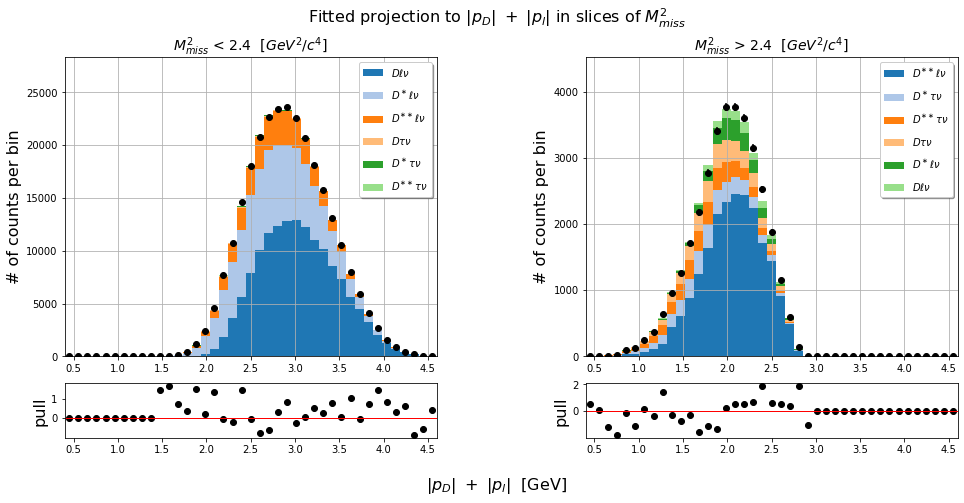

In [35]:
plot_projection_residual(m3, templates_2d, data_2d, direction='p_D_l',slices=True, plot_with='pltbar')

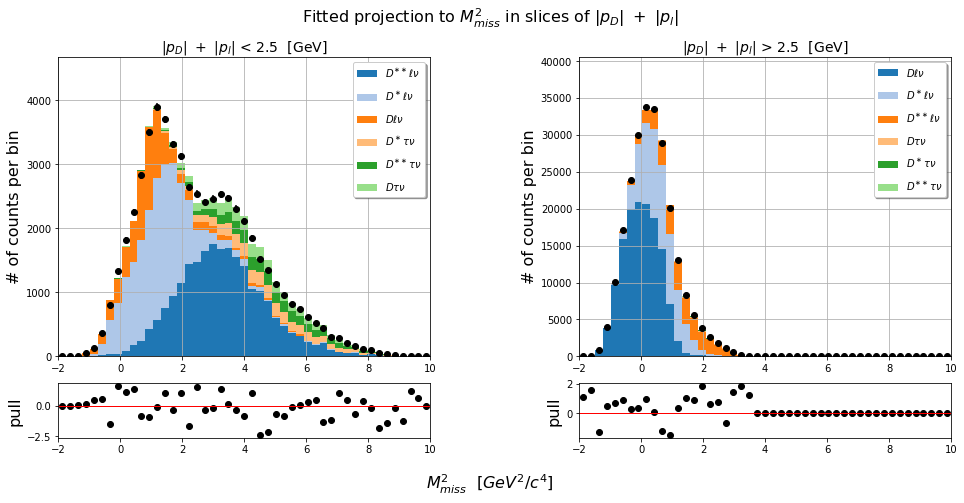

In [36]:
plot_projection_residual(m3, templates_2d, data_2d, direction='MM2',slices=True, plot_with='pltbar')

In [23]:
# plotting version: two residual plots, residual_signal = data - all_temp + signal1
def plot_projection_residual(direction='MM2', slices=False, plot_with='mplhep'):
    if direction not in ['MM2', 'p_D_l'] or plot_with not in ['mplhep', 'pltbar']:
        raise ValueError('direction in [MM2, p_D_l] and plot_with in [mplhep, pltbar]')
    fitted_components_names = samples_name
        # fitted_templates_2d = templates / normalization * yields
    fitted_templates_2d = [templates_2d[i]/templates_2d[i].sum() * Minuit.values[i] for i in range(len(templates_2d))]
    # fitted_templates_err = templates_2d_err, yields_err in quadrature
                         # = fitted_templates_2d x sqrt( (1/templates_2d) + (yield_err/yield)**2 ) if templates_2d[i,j]!=0
                         # = 0 if yield ==0 or templates_2d[i,j]==0
    fitted_templates_err = np.zeros_like(templates_2d)
    non_zero_masks = [np.where(t!= 0) for t in templates_2d]
    for i in range(len(templates_2d)):
        if Minuit.values[i]==0:
            continue
        else:
            fitted_templates_err[i][non_zero_masks[i]] = fitted_templates_2d[i][non_zero_masks[i]] * \
            np.sqrt(1/templates_2d[i][non_zero_masks[i]] + (Minuit.errors[i]/Minuit.values[i])**2)
    
    def extend(x):
        return np.append(x, x[-1])
    
    def errorband(bins, template_sum, template_err, ax):
        fitted_sum = np.sum(template_sum, axis=0)
        fitted_err = np.sqrt(np.sum(np.array(template_err)**2, axis=0)) # assuming the correlations between each template are 0
        ax.fill_between(bins, extend(fitted_sum - fitted_err), extend(fitted_sum + fitted_err),
        step="post", color="black", alpha=0.3, linewidth=0, zorder=100,)   
    
    def plot_with_hep(bins, templates_project, templates_project_err, data, signal_name, ax1, ax2, ax3):
        data_project = data.sum(axis=axis_to_be_summed_over)
        # plot the templates and data
        hep.histplot(templates_project, bin_edges, stack=True, histtype='fill', sort='yield_r', label=fitted_components_names, ax=ax1)
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        hep.histplot(data_project, bin_edges, histtype='errorbar', color='black', w2=data_project, ax=ax1)
        # plot the residual
        signal_index = fitted_components_names.index(signal_name)
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signal = residual + templates_project[signal_index]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signal = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index]))
        
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        pull_signal = [0 if residual_err_signal[i]==0 else (residual_signal[i]/residual_err_signal[i]) for i in range(len(residual_signal))]
        #hep.histplot(residual, bin_edges, histtype='errorbar', color='black', yerr=residual_err, ax=ax2)
        hep.histplot(pull, bin_edges, histtype='errorbar', color='black', ax=ax2)
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        #hep.histplot(residual_signal, bin_edges, histtype='errorbar', color='black', yerr=residual_err_signal, ax=ax3)
        hep.histplot(pull_signal, bin_edges, histtype='errorbar', color='black', ax=ax3)
        ax3.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('pull',fontsize=14)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax3.set_ylabel('pull + signal',fontsize=10)
        ax3.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
        
    def plot_with_bar(bins, templates_project, templates_project_err, data, signal_name, ax1, ax2, ax3):        
        # calculate the arguments for plotting
        bin_width = bins[1]-bins[0]
        bin_centers = (bins[:-1] + bins[1:]) /2
        data_project = data.sum(axis=axis_to_be_summed_over)
        data_err = np.sqrt(data_project)
        
        # plot the templates
        # sort the components to plot in order of fitted templates_project size
        sorted_indices = sorted(range(len(templates_2d)), key=lambda i: np.sum(templates_project[i]), reverse = True)
        bottom_hist = np.zeros(data.shape[1-axis_to_be_summed_over])
        for i in sorted_indices:
            binned_counts = templates_project[i]
            ax1.bar(x=bins[:-1], height=binned_counts, bottom=bottom_hist,
                    width=bin_width, align='edge', label=f"{fitted_components_names[i]}")
            bottom_hist = bottom_hist + binned_counts
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        
        # plot the data
        ax1.errorbar(x=bin_centers, y=data_project, yerr=data_err, fmt='ko')
        # plot the residual
        signal_index = fitted_components_names.index(signal_name)
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signal = residual + templates_project[signal_index]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signal = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index]))
        
        pull = [0 if residual_err[i]==0 else (residual[i]/residual_err[i]) for i in range(len(residual))]
        pull_signal = [0 if residual_err_signal[i]==0 else (residual_signal[i]/residual_err_signal[i]) for i in range(len(residual_signal))]
        ax2.scatter(x=bin_centers, y=pull, c='black')
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        ax3.scatter(x=bin_centers, y=pull_signal, c='black')
        ax3.axhline(y=0, linestyle='-', linewidth=1, color='r')
                
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('pull',fontsize=14)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax3.set_ylabel('pull + signal',fontsize=10)
        ax3.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)       
    
    if direction=='MM2':
        direction_label = '$M_{miss}^2$'
        direction_unit = '$[GeV^2/c^4]$'
        other_direction_label = '$|p_D|\ +\ |p_l|$'
        other_direction_unit = '[GeV]'
        slice1_signal = '$D\\tau\\nu$'
        slice2_signal = '$D\\ell\\nu$'
        slice_position = p_D_l_slice
        axis_to_be_summed_over = 0
        bin_edges = xedges
        first_slice_index = (p_D_l_slice_index[0]-1)
        second_slice_index = (p_D_l_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:first_slice_index,:]
        data_slice2 = counts[second_slice_index:,:]
        
    elif direction=='p_D_l':
        direction_label = '$|p_D|\ +\ |p_l|$'
        direction_unit = '[GeV]'
        other_direction_label = '$M_{miss}^2$'
        other_direction_unit = '$[GeV^2/c^4]$'
        slice1_signal = '$D\\ell\\nu$'
        slice2_signal = '$D\\tau\\nu$'
        slice_position = mm2_slice
        axis_to_be_summed_over = 1
        bin_edges = yedges
        first_slice_index = (mm2_slice_index[0]-1)
        second_slice_index = (mm2_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:,:first_slice_index]
        data_slice2 = counts[:,second_slice_index:]

        
    else:
        raise ValueError('Current version only supports projection to either MM2 or p_D_l')


    if not slices:
        fig = plt.figure(figsize=(6.4,6.4))
        gs = gridspec.GridSpec(3,1, height_ratios=[0.7,0.15,0.15])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        ax3 = fig.add_subplot(gs[2])
        gs.update(hspace=0.3) 
        fitted_project = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_err = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        
        # plot the templates and data and templates_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project, fitted_project_err, counts, '$D\\tau\\nu$', ax1, ax2,ax3)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project, fitted_project_err, counts, '$D\\tau\\nu$', ax1, ax2,ax3)
        ax1.set_title(f'Fitting projection to {direction_label}')
        ax3.set_xlabel(direction_label)
    
    elif slices:
        fig = plt.figure(figsize=(16,7))
        spec = gridspec.GridSpec(6,2, figure=fig, wspace=0.4, hspace=0.5)
        ax1 = fig.add_subplot(spec[:-2, 0])
        ax2 = fig.add_subplot(spec[:-2, 1])
        ax3 = fig.add_subplot(spec[-2, 0])
        ax4 = fig.add_subplot(spec[-2, 1])
        ax5 = fig.add_subplot(spec[-1, 0])
        ax6 = fig.add_subplot(spec[-1, 1])
        #gs.update(hspace=0) 
        
        # plot the templates and data and template_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signal, ax1, ax3, ax5)
            plot_with_hep(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signal, ax2, ax4, ax6)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signal, ax1, ax3, ax5)
            plot_with_bar(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signal, ax2, ax4, ax6)
            
        ax1.set_title(f'{other_direction_label} < {slice_position}  {other_direction_unit}')
        ax2.set_title(f'{other_direction_label} > {slice_position}  {other_direction_unit}')
        fig.suptitle(f'Fitted projection to {direction_label} in slices of {other_direction_label}')
        fig.supxlabel(direction_label + '  ' + direction_unit)

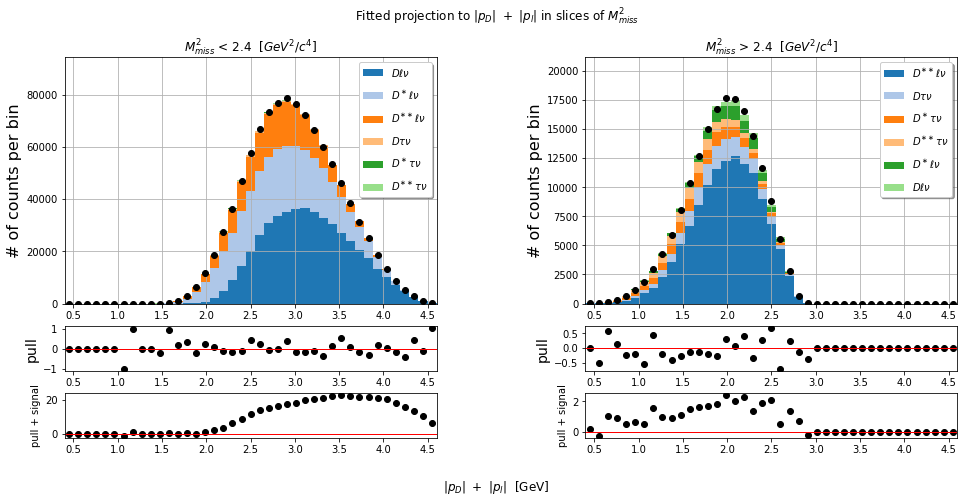

In [24]:
plot_projection_residual(direction='p_D_l',slices=True, plot_with='pltbar')

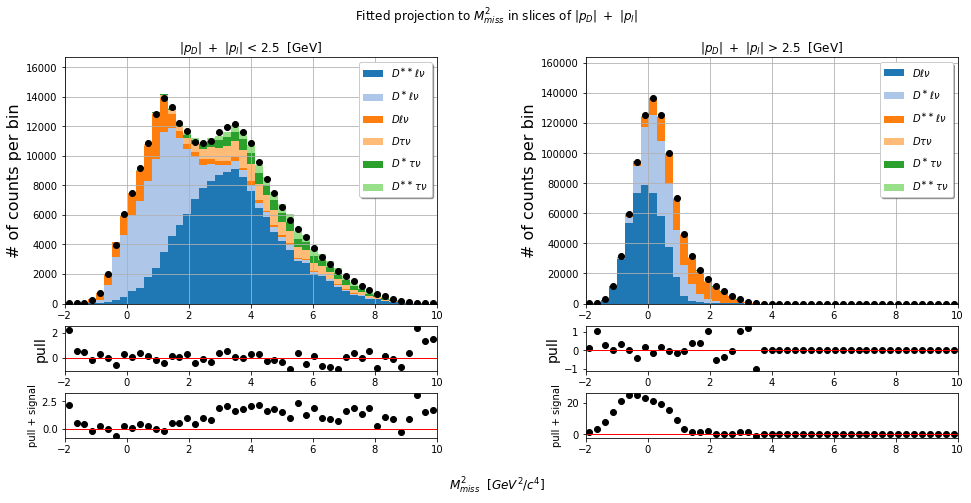

In [25]:
plot_projection_residual(direction='MM2',slices=True, plot_with='pltbar')

In [ ]:
# plotting version: residual_signals = data - all_temp + signal1 + signal2
def plot_projection_residual(direction='MM2', slices=False, plot_with='mplhep'):
    if direction not in ['MM2', 'p_D_l'] or plot_with not in ['mplhep', 'pltbar']:
        raise ValueError('direction in [MM2, p_D_l] and plot_with in [mplhep, pltbar]')
    fitted_components_names = samples_name
        # fitted_templates_2d = templates / normalization * yields
    fitted_templates_2d = [templates_2d[i]/templates_2d[i].sum() * Minuit.values[i] for i in range(len(templates_2d))]
    # fitted_templates_err = templates_2d_err, yields_err in quadrature
                         # = fitted_templates_2d x sqrt( (1/templates_2d) + (yield_err/yield)**2 ) if templates_2d[i,j]!=0
                         # = 0 if yield ==0 or templates_2d[i,j]==0
    fitted_templates_err = np.zeros_like(templates_2d)
    non_zero_masks = [np.where(t!= 0) for t in templates_2d]
    for i in range(len(templates_2d)):
        if Minuit.values[i]==0:
            continue
        else:
            fitted_templates_err[i][non_zero_masks[i]] = fitted_templates_2d[i][non_zero_masks[i]] * \
            np.sqrt(1/templates_2d[i][non_zero_masks[i]] + (Minuit.errors[i]/Minuit.values[i])**2)
    
    def extend(x):
        return np.append(x, x[-1])
    
    def errorband(bins, template_sum, template_err, ax):
        fitted_sum = np.sum(template_sum, axis=0)
        fitted_err = np.sqrt(np.sum(np.array(template_err)**2, axis=0)) # assuming the correlations between each template are 0
        ax.fill_between(bins, extend(fitted_sum - fitted_err), extend(fitted_sum + fitted_err),
        step="post", color="black", alpha=0.3, linewidth=0, zorder=100,)
        
    def plot_with_hep(bins, templates_project, templates_project_err, data, signal_names, ax1, ax2):
        data_project = data.sum(axis=axis_to_be_summed_over)
        # plot the templates and data
        hep.histplot(templates_project, bin_edges, stack=True, histtype='fill', sort='yield_r', label=fitted_components_names, ax=ax1)
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        hep.histplot(data_project, bin_edges, histtype='errorbar', color='black', w2=data_project, ax=ax1)
        # plot the residual
        signal_index1 = fitted_components_names.index(signal_names[0])
        signal_index2 = fitted_components_names.index(signal_names[1])
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signals = residual + templates_project[signal_index1] + templates_project[signal_index2]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signals = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index1]) - np.array(templates_project_err[signal_index2]))
        hep.histplot(residual_signals, bin_edges, histtype='errorbar', color='black', yerr=residual_err_signals, ax=ax2)
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('Data-Bkg',fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
        
    def plot_with_bar(bins, templates_project, templates_project_err, data, signal_names, ax1, ax2):        
        # calculate the arguments for plotting
        bin_width = bins[1]-bins[0]
        bin_centers = (bins[:-1] + bins[1:]) /2
        data_project = data.sum(axis=axis_to_be_summed_over)
        data_err = np.sqrt(data_project)
        
        # plot the templates
        # sort the components to plot in order of fitted templates_project size
        sorted_indices = sorted(range(len(templates_2d)), key=lambda i: np.sum(templates_project[i]), reverse = True)
        bottom_hist = np.zeros(data.shape[1-axis_to_be_summed_over])
        for i in sorted_indices:
            binned_counts = templates_project[i]
            ax1.bar(x=bins[:-1], height=binned_counts, bottom=bottom_hist,
                    width=bin_width, align='edge', label=f"{fitted_components_names[i]}")
            bottom_hist = bottom_hist + binned_counts
        # errorband(bin_edges, templates_project, templates_project_err, ax1)
        
        # plot the data
        ax1.errorbar(x=bin_centers, y=data_project, yerr=data_err, fmt='ko')
        # plot the residual
        signal_index1 = fitted_components_names.index(signal_names[0])
        signal_index2 = fitted_components_names.index(signal_names[1])
        residual = data_project - np.sum(templates_project, axis=0)
        residual_signals = residual + templates_project[signal_index1] + templates_project[signal_index2]
        # Error assuming the correlations between data and templates, between each template, are 0
        residual_err = np.sqrt(data_project + np.sum(np.array(templates_project_err)**2, axis=0))
        residual_err_signals = np.sqrt(residual_err**2 - np.array(templates_project_err[signal_index1]) - np.array(templates_project_err[signal_index2]))
        ax2.errorbar(x=bin_centers, y=residual_signals, yerr=residual_err_signals, fmt='ko')
        ax2.axhline(y=0, linestyle='-', linewidth=1, color='r')
        
        ax1.grid()
        ax1.set_ylabel('# of counts per bin',fontsize=16)
        ax1.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.set_ylim(0, data_project.max()*1.2)
        ax2.set_ylabel('Data-Bkg',fontsize=16)
        ax2.set_xlim(bin_edges.min(), bin_edges.max())
        ax1.legend(bbox_to_anchor=(1,1),ncol=1, fancybox=True, shadow=True,labelspacing=1)
    
    if direction=='MM2':
        direction_label = '$M_{miss}^2$'
        direction_unit = '$[GeV^2/c^4]$'
        other_direction_label = '$|p_D|\ +\ |p_l|$'
        other_direction_unit = '[GeV]'
        slice1_signals = ['D_tau_nu', 'Dst_tau_nu']
        slice2_signals = ['D_l_nu', 'Dst_l_nu']
        slice_position = p_D_l_slice
        axis_to_be_summed_over = 0
        bin_edges = xedges
        first_slice_index = (p_D_l_slice_index[0]-1)
        second_slice_index = (p_D_l_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:first_slice_index,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[second_slice_index:,:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:first_slice_index,:]
        data_slice2 = counts[second_slice_index:,:]
        
    elif direction=='p_D_l':
        direction_label = '$|p_D|\ +\ |p_l|$'
        direction_unit = '[GeV]'
        other_direction_label = '$M_{miss}^2$'
        other_direction_unit = '$[GeV^2/c^4]$'
        slice1_signals = ['D_l_nu', 'Dst_l_nu']
        slice2_signals = ['D_tau_nu', 'Dst_tau_nu']
        slice_position = mm2_slice
        axis_to_be_summed_over = 1
        bin_edges = yedges
        first_slice_index = (mm2_slice_index[0]-1)
        second_slice_index = (mm2_slice_index[0])
        
        # parameters for slices==True
        fitted_project_slice1 = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice2 = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_slice1_err = [temp[:,:first_slice_index].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        fitted_project_slice2_err = [temp[:,second_slice_index:].sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        data_slice1 = counts[:,:first_slice_index]
        data_slice2 = counts[:,second_slice_index:]
        
        
    else:
        raise ValueError('Current version only supports projection to either MM2 or p_D_l')
    
    if not slices:
        fig = plt.figure(figsize=(6.4,6.4))
        gs = gridspec.GridSpec(3,1, height_ratios=[0.8,0.2])
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1])
        #gs.update(hspace=0.3) 
        fitted_project = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates]
        fitted_project_err = [temp.sum(axis=axis_to_be_summed_over) for temp in fitted_templates_err]
        
        # plot the templates and data and templates_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project, fitted_project_err, counts, 'D_tau_nu', ax1, ax2)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project, fitted_project_err, counts, 'D_tau_nu', ax1, ax2)
        ax1.set_title(f'Fitting projection to {direction_label}')
        ax2.set_xlabel(direction_label)
    
    elif slices:
        fig = plt.figure(figsize=(16,7))
        spec = gridspec.GridSpec(5,2, figure=fig, wspace=1, hspace=0.5)
        ax1 = fig.add_subplot(spec[:-1, 0])
        ax2 = fig.add_subplot(spec[:-1, 1])
        ax3 = fig.add_subplot(spec[-1, 0])
        ax4 = fig.add_subplot(spec[-1, 1])
        #gs.update(hspace=0) 
        
        # plot the templates and data and template_err
        if plot_with=='mplhep':
            plot_with_hep(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signals, ax1, ax3)
            plot_with_hep(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signals, ax2, ax4)
        elif plot_with=='pltbar':
            plot_with_bar(bin_edges, fitted_project_slice1, fitted_project_slice1_err, data_slice1, slice1_signals, ax1, ax3)
            plot_with_bar(bin_edges, fitted_project_slice2, fitted_project_slice2_err, data_slice2, slice2_signals, ax2, ax4)
            
        ax1.set_title(f'{other_direction_label} < {slice_position}  {other_direction_unit}')
        ax2.set_title(f'{other_direction_label} > {slice_position}  {other_direction_unit}')
        fig.suptitle(f'Fitted projection to {direction_label} in slices of {other_direction_label}')
        fig.supxlabel(direction_label + '  ' + direction_unit)